# The search for dark vessels: AIS / ship detection fusion workflow

All ships above a certain size are by law required to use an AIS (Automated Identification System) transponder and
are therefore trackable at all times wherever they go. A ship without such a signal is called a "dark vessel". While
there are not always sinister reasons for this behaviour this quite often indicates that something "fishy" is going
on. Not surprisingly there are many organisations which are interested in this kind of information.

In the following we show how dark vessels can be identified by combining a Machine Learning-based algorithm working on
satellite images (provided by Airbus) with AIS signals (provided by ExactEarth).

The workflow consists of the following steps:

- Get SPOT imagery for the given AOI
- Execute tiling, ship detection and ship identification blocks via parallel jobs
- Visualize the results

To run the example costs around xxxx UP42 credits.

## Setup

Import required libraries

In [107]:
import up42
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from shapely.geometry import box
import geojson

Configure areas of interest

In [2]:
aoi_akl = {"type":"FeatureCollection","features":[{"type":"Feature","properties":{},
                "geometry":{"type":"Polygon","coordinates":[[[174.758265,-36.840828],
                                                             [174.767042,-36.840828],
                                                             [174.767042,-36.835593],
                                                             [174.758265,-36.835593],
                                                             [174.758265,-36.840828]]]}}]}
aoi_cpt = {"type":"FeatureCollection","features":[{"type":"Feature","properties":{},
                "geometry":{"type":"Polygon","coordinates":[[[18.429276,-33.915919],
                                                             [18.436084,-33.915919],
                                                             [18.436084,-33.909399],
                                                             [18.429276,-33.909399],
                                                             [18.429276,-33.915919]]]}}]}

aois = [{'title': 'AKL', 'geometry': aoi_akl},
        {'title': 'CPT', 'geometry': aoi_cpt}]

Authenticate with UP42

In [5]:
#up42.authenticate(project_id="123", project_api_key="456")
up42.authenticate(cfg_file="config.json")
up42.settings(log=False)

2020-11-26 11:00:31,095 - Got credentials from config file.
2020-11-26 11:00:31,331 - Authentication with UP42 successful!
2020-11-26 11:00:31,332 - Logging disabled - use up42.settings(log=True) to reactivate.


# Catalog Search

Search cloudfree SPOT images for the two aois and visualise the quicklooks.

2020-11-26 11:23:26,094 - Searching catalog with search_parameters: {'datetime': '2019-01-01T00:00:00Z/2020-12-31T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((174.758265, -36.840828), (174.767042, -36.840828), (174.767042, -36.835593), (174.758265, -36.835593), (174.758265, -36.840828)),)}, 'limit': 3, 'query': {'dataBlock': {'in': ['oneatlas-spot-fullscene', 'oneatlas-spot-aoiclipped']}, 'cloudCoverage': {'lte': 5}}, 'sortby': [{'field': 'properties.acquisitionDate', 'direction': 'desc'}]}



---------AKL---------



2020-11-26 11:23:26,493 - 1 results returned.
2020-11-26 11:23:26,535 - Getting quicklooks from provider oneatlas for image_ids: ['5f259634-7988-4703-b685-28dc31150fb6']
2020-11-26 11:23:26,536 - Download directory: /Users/markus.mueller/projects/up42-py/examples/project_2db3c170-7772-4bef-9344-2182421e2938/catalog
100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


geometry  \
0  POLYGON ((174.38418 -36.36942, 175.11048 -36.3...   

                                     id       acquisitionDate constellation  \
0  5f259634-7988-4703-b685-28dc31150fb6  2019-03-02T22:03:46Z          SPOT   

  providerName                                         blockNames  \
0     oneatlas  [oneatlas-spot-fullscene, oneatlas-spot-aoicli...   

   cloudCoverage     up42:usageType  \
0            0.0  [DATA, ANALYTICS]   

                                  providerProperties  \
0  {'commercialReference': 'SO19006759', 'acquisi...   

                                            scene_id  
0  DS_SPOT6_201903022203461_FR1_FR1_SV1_SV1_E175S...

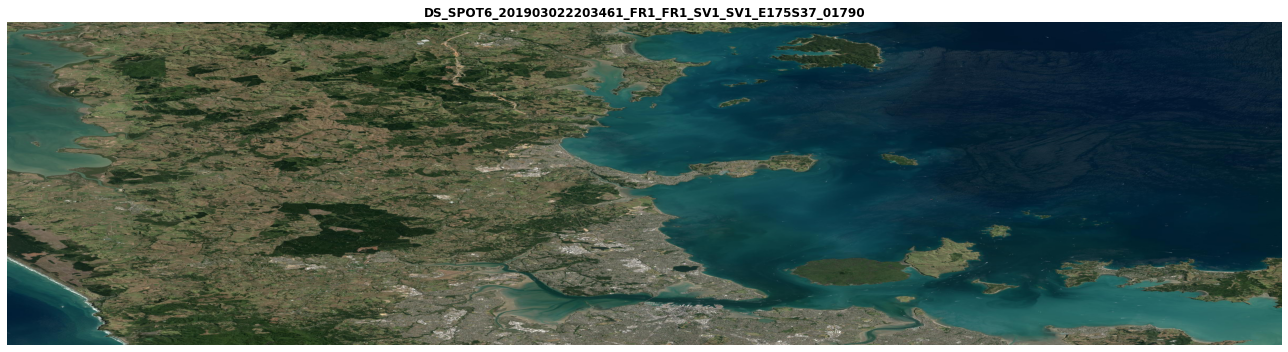

2020-11-26 11:23:28,122 - Searching catalog with search_parameters: {'datetime': '2019-01-01T00:00:00Z/2020-12-31T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((18.429276, -33.915919), (18.436084, -33.915919), (18.436084, -33.909399), (18.429276, -33.909399), (18.429276, -33.915919)),)}, 'limit': 3, 'query': {'dataBlock': {'in': ['oneatlas-spot-fullscene', 'oneatlas-spot-aoiclipped']}, 'cloudCoverage': {'lte': 5}}, 'sortby': [{'field': 'properties.acquisitionDate', 'direction': 'desc'}]}



---------CPT---------



2020-11-26 11:23:28,536 - 3 results returned.
2020-11-26 11:23:28,577 - Getting quicklooks from provider oneatlas for image_ids: ['ae9b18f1-eb1a-4b1f-8c21-04830e25a32d', '69435fc7-f0ca-40a8-97af-54c2f33203d4', 'd7932197-bf4c-434a-b91f-d275db743002']
2020-11-26 11:23:28,578 - Download directory: /Users/markus.mueller/projects/up42-py/examples/project_2db3c170-7772-4bef-9344-2182421e2938/catalog
100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


geometry  \
0  POLYGON ((18.25142 -33.88798, 18.24633 -34.422...   
1  POLYGON ((17.92004 -33.47245, 17.91166 -34.489...   
2  POLYGON ((17.91927 -33.45469, 18.60631 -33.475...   

                                     id       acquisitionDate constellation  \
0  ae9b18f1-eb1a-4b1f-8c21-04830e25a32d  2020-03-03T09:46:46Z          SPOT   
1  69435fc7-f0ca-40a8-97af-54c2f33203d4  2020-02-19T08:32:17Z          SPOT   
2  d7932197-bf4c-434a-b91f-d275db743002  2019-04-21T08:17:42Z          SPOT   

  providerName                                         blockNames  \
0     oneatlas  [oneatlas-spot-fullscene, oneatlas-spot-aoicli...   
1     oneatlas  [oneatlas-spot-fullscene, oneatlas-spot-aoicli...   
2     oneatlas  [oneatlas-spot-fullscene, oneatlas-spot-aoicli...   

   cloudCoverage     up42:usageType  \
0           0.00  [DATA, ANALYTICS]   
1           1.32  [DATA, ANALYTICS]   
2           1.17  [DATA, ANALYTICS]   

                                  providerProperties  \
0  {'acquisitionDate': '2020-03-03T09:46:46Z', 'q...   
1  {'commercialReference': 'SO20065154', 'acquisi...   
2  {'commercialReference': 'SO19013271', 'acquisi...   

                                            scene_id  
0  DS_SPOT7_202003030832162_FR1_FR1_FR1_FR1_E019S...  
1  DS_SPOT6_202002190832176_FR1_FR1_FR1_FR1_E018S...  
2  DS_SPOT7_201904210817425_FR1_FR1_SV1_SV1_E018S...

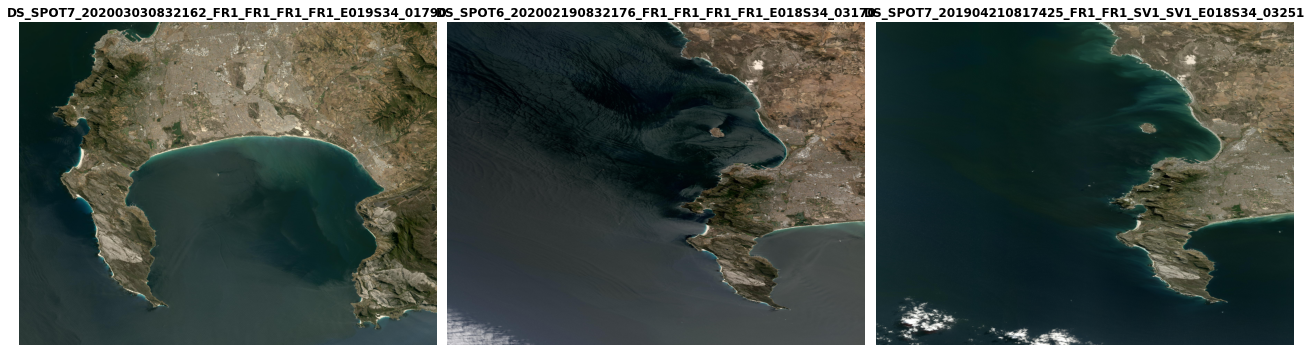

In [27]:
catalog = up42.initialize_catalog()


for aoi in aois:
    print("\n---------" + aoi["title"] + "---------\n")
    search_paramaters = catalog.construct_parameters(geometry=aoi['geometry'], 
                                                     start_date="2019-01-01",
                                                     end_date="2020-12-31",
                                                     sensors=["spot"],
                                                     max_cloudcover=5,
                                                     sortby="acquisitionDate",
                                                     ascending=False,
                                                     limit=3)
    search_results = catalog.search(search_paramaters)
    
    # Download & Visualise quicklooks
    catalog.download_quicklooks(image_ids=search_results.id.to_list(), sensor="spot")
    display(search_results.head())
    catalog.plot_quicklooks(figsize=(18,5), titles=search_results.scene_id.to_list())

    # Select least cloud scene for further workflow
    aoi["scene_id"] = search_results.scene_id.to_list()[0]

In [10]:
# Optional: Select ideal scenes manually
aois[0]["scene_id"] = "DS_PHR1B_202004281031350_FR1_PX_E013N52_0513_01239"
aois[1]["scene_id"] = "DS_PHR1B_202004161025425_FR1_PX_E011N48_1009_00822"

## Download selected SPOT images for aois

In [28]:
up42.settings(log=True)
project = up42.initialize_project()

# Increase the parallel job limit for the project.
#project.update_project_settings(max_concurrent_jobs=10)

2020-11-26 11:25:13,833 - Logging enabled (default) - use up42.settings(log=False) to disable.
2020-11-26 11:25:14,504 - Initialized Project(name: Dark vessels, project_id: 2db3c170-7772-4bef-9344-2182421e2938, description: Project used for the AIS webinar, createdAt: 2020-11-25T08:08:47.717742Z)


Create or update a workflow for the ship identification

In [29]:
workflow = project.create_workflow("Ship identification", use_existing=True)

2020-11-26 11:25:30,155 - Getting existing workflows in project ...
2020-11-26 11:25:30,798 - Got 1 workflows for project 2db3c170-7772-4bef-9344-2182421e2938.
100%|██████████| 1/1 [00:00<00:00,  2.86it/s]
2020-11-26 11:25:31,150 - Using existing workflow: Ship identification - e9cca692-e320-4b31-aac8-e2b024c474d1


Add or update workflows tasks

In [31]:
#up42.get_blocks(basic=True)
input_tasks= ['oneatlas-spot-aoiclipped', 'tiling', 'ship-detection', 'ship-identification']
workflow.add_workflow_tasks(input_tasks=input_tasks)
workflow

2020-11-26 11:26:01,178 - Added tasks to workflow: [{'name': 'oneatlas-spot-aoiclipped:1', 'parentName': None, 'blockId': '045019bb-06fc-4fa1-b703-318725b4d8af'}, {'name': 'tiling:1', 'parentName': 'oneatlas-spot-aoiclipped:1', 'blockId': '3e146dd6-2b67-4d6e-a422-bb3d973e32ff'}, {'name': 'ship-detection:1', 'parentName': 'tiling:1', 'blockId': '79e3e48c-d65f-4528-a6d4-e8d20fecc93c'}, {'name': 'ship-identification:1', 'parentName': 'ship-detection:1', 'blockId': '54217695-73f4-4528-a575-a429e9af6568'}]


Workflow(name: Ship identification, workflow_id: e9cca692-e320-4b31-aac8-e2b024c474d1, description: , createdAt: 2020-11-26T10:12:29.746194Z, project_id: 2db3c170-7772-4bef-9344-2182421e2938, workflow_tasks: {'oneatlas-spot-aoiclipped:1': '2.1.3', 'tiling:1': '2.2.3', 'ship-detection:1': '5.2.0-public', 'ship-identification:1': '2.3.0'}

### Run jobs in parallel

Construct workflow input parameters & run jobs

In [32]:
input_parameters_list = []

for aoi in aois:
    input_parameters = workflow.construct_parameters(geometry=aoi['geometry'], 
                                                     geometry_operation="bbox", 
                                                     scene_ids=[aoi["scene_id"]])
    #input_parameters['tiling:1']['tile_width']  = 1024
    #input_parameters['tiling:1']['tile_height'] = 1024
    input_parameters_list.append(input_parameters)

input_parameters_list

[{'oneatlas-spot-aoiclipped:1': {'limit': 1,
   'zoom_level': 17,
   'max_cloud_cover': 100,
   'panchromatic_band': False,
   'ids': ['DS_SPOT6_201903022203461_FR1_FR1_SV1_SV1_E175S37_01790'],
   'bbox': [174.758265, -36.840828, 174.767042, -36.835593]},
  'tiling:1': {'tile_width': 768,
   'tile_height': 768,
   'match_extents': False,
   'output_prefix': '',
   'augmentation_factor': 1,
   'discard_empty_tiles': True},
  'ship-detection:1': {},
  'ship-identification:1': {'minutes': 15}},
 {'oneatlas-spot-aoiclipped:1': {'limit': 1,
   'zoom_level': 17,
   'max_cloud_cover': 100,
   'panchromatic_band': False,
   'ids': ['DS_SPOT7_202003030832162_FR1_FR1_FR1_FR1_E019S34_01790'],
   'bbox': [18.429276, -33.915919, 18.436084, -33.909399]},
  'tiling:1': {'tile_width': 768,
   'tile_height': 768,
   'match_extents': False,
   'output_prefix': '',
   'augmentation_factor': 1,
   'discard_empty_tiles': True},
  'ship-detection:1': {},
  'ship-identification:1': {'minutes': 15}}]

In [33]:
jobs = workflow.run_jobs_parallel(input_parameters_list=input_parameters_list)

2020-11-26 11:35:40,564 - Selected input_parameters: {'oneatlas-spot-aoiclipped:1': {'limit': 1, 'zoom_level': 17, 'max_cloud_cover': 100, 'panchromatic_band': False, 'ids': ['DS_SPOT6_201903022203461_FR1_FR1_SV1_SV1_E175S37_01790'], 'bbox': [174.758265, -36.840828, 174.767042, -36.835593]}, 'tiling:1': {'tile_width': 768, 'tile_height': 768, 'match_extents': False, 'output_prefix': '', 'augmentation_factor': 1, 'discard_empty_tiles': True}, 'ship-detection:1': {}, 'ship-identification:1': {'minutes': 15}}.
2020-11-26 11:35:44,827 - Created and running new job: f9828c00-92d7-43d2-83e2-03c08765999d
2020-11-26 11:35:45,179 - Selected input_parameters: {'oneatlas-spot-aoiclipped:1': {'limit': 1, 'zoom_level': 17, 'max_cloud_cover': 100, 'panchromatic_band': False, 'ids': ['DS_SPOT7_202003030832162_FR1_FR1_FR1_FR1_E019S34_01790'], 'bbox': [18.429276, -33.915919, 18.436084, -33.909399]}, 'tiling:1': {'tile_width': 768, 'tile_height': 768, 'match_extents': False, 'output_prefix': '', 'augmen

### Download & Visualise results

In [43]:
jobtask = job.get_jobtasks()

2020-11-27 07:52:36,867 - Getting job tasks: 7e401e8f-c486-44e5-a2f5-8ca03adb44d6


In [108]:
data_results_paths, detection_results, identification_results = [], [], []
for job in jobs:
    data_task, _, detection_task, identification_task = job.get_jobtasks()
    data_paths = data_task.download_results()
    data_results_paths.append([p for p in data_paths if p.endswith(".tif")])    
    detection_results.append(detection_task.get_results_json())
    #identification_results.append(identification_task.get_results_json())
    identification_paths = identification_task.download_results()
    geojson_path = [p for p in identification_paths if p.endswith(".geojson")][0]
    with open(geojson_path) as f:
        gj = geojson.load(f)
    identification_results.append(gj)

2020-11-27 14:28:24,651 - Getting job tasks: f9828c00-92d7-43d2-83e2-03c08765999d
2020-11-27 14:28:26,681 - Downloading results of jobtask 3a188443-45a9-43b4-b318-d5ab35c0a7ee
2020-11-27 14:28:26,682 - Download directory: /Users/markus.mueller/projects/up42-py/examples/project_2db3c170-7772-4bef-9344-2182421e2938/job_f9828c00-92d7-43d2-83e2-03c08765999d/jobtask_3a188443-45a9-43b4-b318-d5ab35c0a7ee
2897it [00:00, 224434.77it/s]
2020-11-27 14:28:27,859 - Download successful of 3 files to output_directory '/Users/markus.mueller/projects/up42-py/examples/project_2db3c170-7772-4bef-9344-2182421e2938/job_f9828c00-92d7-43d2-83e2-03c08765999d/jobtask_3a188443-45a9-43b4-b318-d5ab35c0a7ee': ['usage.json', 'data.json', 'c91429aa-1a0d-497f-a53c-9069e72c683c.tif']
2020-11-27 14:28:28,288 - Retrieved 17 features.
2020-11-27 14:28:28,289 - Downloading results of jobtask 37f233e6-1acb-4470-9af3-fd3422b6432c
2020-11-27 14:28:28,291 - Download directory: /Users/markus.mueller/projects/up42-py/examples/p

In [99]:
data_paths

['/Users/markus.mueller/projects/up42-py/examples/project_2db3c170-7772-4bef-9344-2182421e2938/job_7e401e8f-c486-44e5-a2f5-8ca03adb44d6/jobtask_f2540f5c-fb23-49c6-9dce-97f2a4f38b87/usage.json',
 '/Users/markus.mueller/projects/up42-py/examples/project_2db3c170-7772-4bef-9344-2182421e2938/job_7e401e8f-c486-44e5-a2f5-8ca03adb44d6/jobtask_f2540f5c-fb23-49c6-9dce-97f2a4f38b87/data.json',
 '/Users/markus.mueller/projects/up42-py/examples/project_2db3c170-7772-4bef-9344-2182421e2938/job_7e401e8f-c486-44e5-a2f5-8ca03adb44d6/jobtask_f2540f5c-fb23-49c6-9dce-97f2a4f38b87/819e7607-367d-4865-b235-b86ea3d265e5.tif']

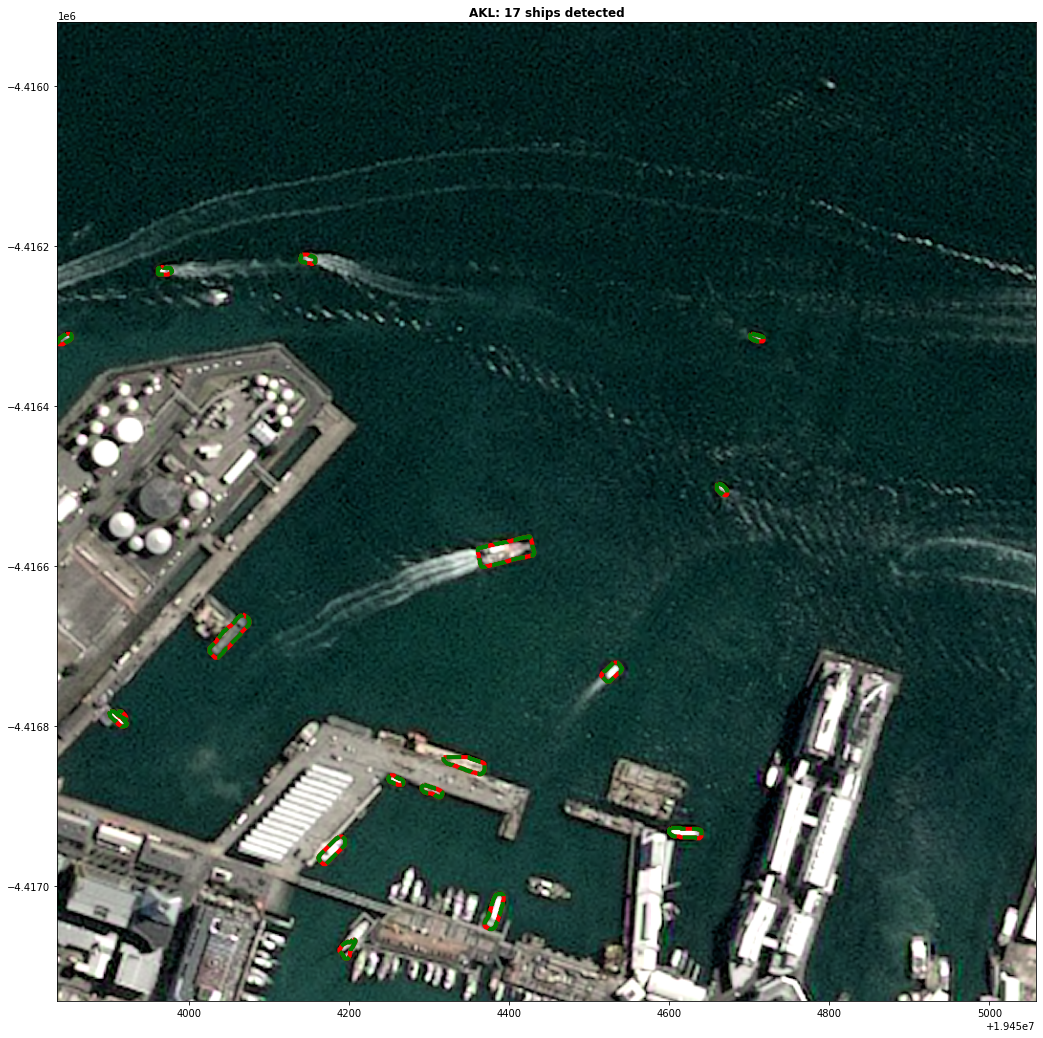

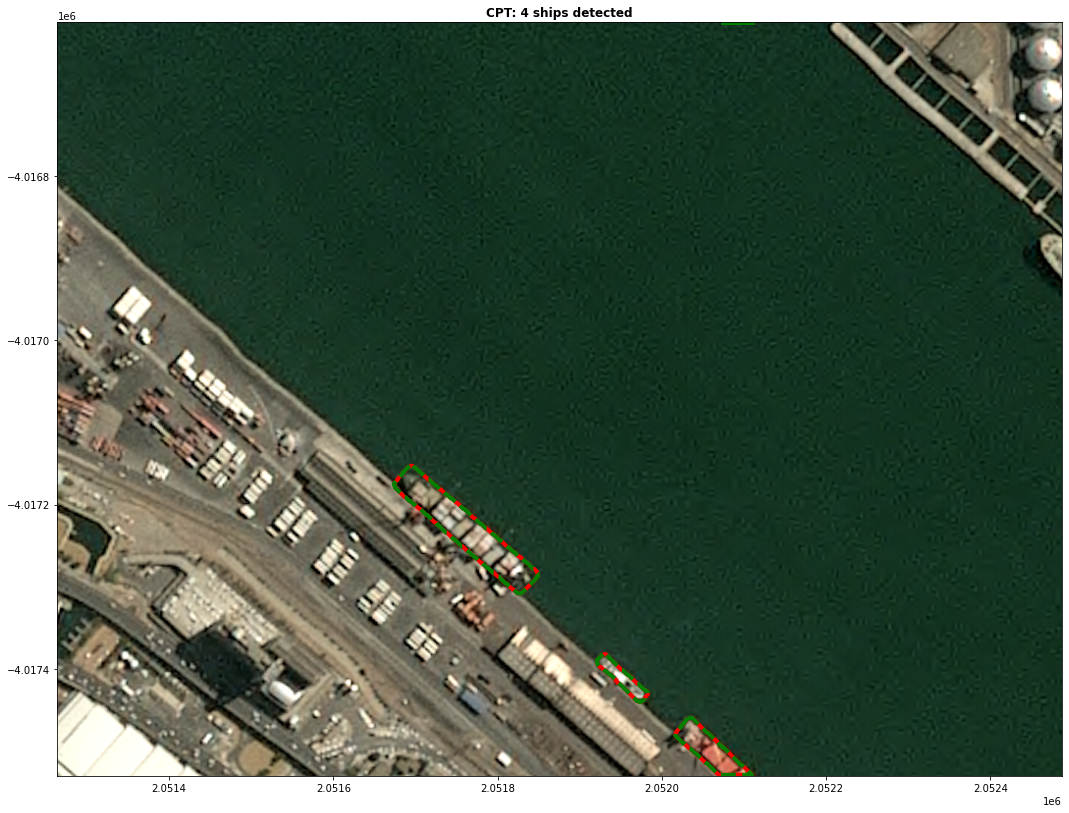

In [114]:
for i, (paths, detection, identification) in enumerate(zip(data_results_paths, detection_results, identification_results)):
    with rasterio.open(paths[0]) as src:
        fig, ax = plt.subplots(figsize=(18, 18))

        ships = gpd.GeoDataFrame.from_features(detection, crs="epsg:4326")
        ships = ships.to_crs(epsg=3857)
        ships_ais = gpd.GeoDataFrame.from_features(identification, crs="urn:ogc:def:crs:OGC:1.3:CRS84")
        ships_ais = ships.to_crs(epsg=3857)

        show(src.read(), transform=src.transform, ax=ax, title=f"{aois[i]['title']}: {ships.shape[0]} ships detected")
    
        ships.plot(ax=ax, facecolor=(0,0,0,0), edgecolor='red', linewidth=4)
        ships.plot(ax=ax, facecolor=(0,0,0,0), edgecolor='green', linestyle="dashed", linewidth=4)
        
        plt.show()